In [1]:
#| default_exp MultiModal


My [Nano GPT](https://tripathysagar.github.io/sagaTrip/gptdecoder.html) model could write Shakespeare-style text. Cool. But it had no idea what a boot looked like. Time to teach it.

But here's the problem: images and text are fundamentally different beasts. Text? Nice, tidy tokens. Images? Thousands of pixels, each with values from 0-255. The model needs to make sense of *both* simultaneously.

**Aim:** Following the spirit of faster iteration and rapid experimentation, I built a text-to-text model (takes text input, predicts text output). The goal: expand this to handle **multimodal inputs**—learning to generate text captions from images.

The experiment uses Shakespeare text for language modeling and Fashion-MNIST images with captions for vision-language tasks. This architecture pattern is similar to modern models like LLaVA. The model learns that `👢 → 'simple boot'`

Please check the complete [blog](https://tripathysagar.github.io/sagaTrip/multimodal.html) and inspiration.


In [2]:
try:
    import google.colab
    !pip install -q git+https://github.com/tripathysagar/NanoTransformer.git
except Exception as e:
    pass

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
#|export
from NanoTransformer.data import *
from NanoTransformer.GPTText2Text import *
from NanoTransformer.ImageEncoder import *

In [4]:
#|export

#text dataloders
text_dl = get_text_dl()
text_dl

{'train': <torch.utils.data.dataloader.DataLoader at 0x7dbe9bad4110>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7dbe9bad4740>}

In [5]:
for x,y in text_dl['train']:
    break
x.shape, y.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

In [6]:
#|export

from fastcore.all import *
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch

In [7]:
train_ds = MNISTDataset(tokenizer, path)
im, lbl_inp, lbl_tgt = train_ds[0]
im.shape, lbl_inp, lbl_tgt

(torch.Size([1, 28, 28]),
 tensor([43, 60, 43, 56, 63, 42, 39, 63,  1, 40, 53, 53, 58]),
 tensor([43, 60, 43, 56, 63, 42, 39, 63,  1, 40, 53, 53, 58,  0]))

In [8]:
tokenizer.decode(lbl_inp), tokenizer.decode(lbl_tgt)

('everyday boot', 'everyday boot\n')

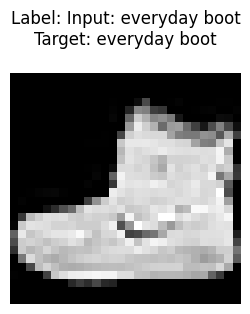

In [9]:
show_images(im, f"Input: {tokenizer.decode(lbl_inp)}\nTarget: {tokenizer.decode(lbl_tgt)}")

In [10]:
#|export

vision_dl = get_mnist_caption_dl(tokenizer, path, 512)
len(vision_dl['train']), len(vision_dl['valid'])

(118, 20)

In [11]:
len(text_dl['train']), len(text_dl['valid'])

(123, 14)

In [12]:
ims, inp, tgt = next(iter(vision_dl['train']))

assert ims.shape[0] == inp.shape[0] == tgt.shape[0]
assert ims.shape[1:] == torch.Size([1, 28, 28])
inp.shape, tgt.shape

(torch.Size([512, 19]), torch.Size([512, 20]))

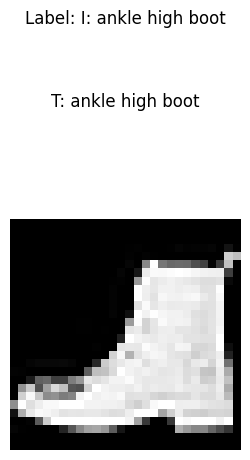

In [13]:
show_images(ims[0], f"I: {tokenizer.decode(inp[0])}T: {tokenizer.decode(tgt[0])}")

## Training Vision Encoder

In [14]:
# train the vison encoder
vision_encoder_train(classifier, 5)

Epoch 	Train Loss 	Valid Loss 	accurecy
1   	0.4333   	0.3317		0.8771
2   	0.2924   	0.3112		0.8847
3   	0.2445   	0.2899		0.8930
4   	0.2120   	0.2516		0.9079
5   	0.1831   	0.2582		0.9099


## Model

Updating the embedding to take in image in first postions, by adding a paramer `start_idx` and defults to `0` for image it will be `1`.

In [15]:
#|export
import torch
from torch import nn
class Embedding(nn.Module):
    def __init__(self, config:GPTConfig):
        super().__init__()
        self.register_buffer('pos_ids', torch.arange(config.seq_len))  # for adding the postional encoding from 0 to seq_len - 1

        self.embed = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.pos_embed =  nn.Embedding(config.seq_len, config.embedding_dim)

    def forward(self, x, start_idx=0):           #bs * seq_len
        return self.embed(x) + self.pos_embed(self.pos_ids[start_idx:start_idx+x.size(1)])     #bs * seq_len * embedding_dim


In [16]:
#|export
class MultiModal(nn.Module):
    def __init__(self):
        super().__init__()

        self.vis_encoder = classifier[0]
        self.proj_layer = nn.Linear(visConfig.head_op_dim, gptConfig.embedding_dim)

        self.embed = Embedding(gptConfig)
        self.blocks = nn.ModuleList(
            [
                nn.Sequential(MultiHeadAttention(gptConfig), FFN(gptConfig))
                for _ in range(gptConfig.n_layers)
            ])
        self.layer_norm = nn.LayerNorm(gptConfig.embedding_dim)
        self.lm_head = nn.Linear(gptConfig.embedding_dim, gptConfig.vocab_size)

        for param in self.vis_encoder.parameters():       #freezing the vision encoder
            param.requires_grad = False

    def forward(self, text_idx, image=None):
        if image is not None:
            # Ensure image has the correct dtype before passing to the encoder
            image = image.to(self.proj_layer.weight.dtype)                     # ensure the image input has the correct data type
            img_emb = self.proj_layer(self.vis_encoder(image)).unsqueeze(1)    # (bs, 1, 128)
            img_emb = img_emb + self.embed.pos_embed(self.embed.pos_ids[0:1])  # fetch embeddings at the 0th idx
            text_emb = self.embed(text_idx, start_idx=1)                       # positions start at 1
            x = torch.cat([img_emb, text_emb], dim=1)
        else:
            x = self.embed(text_idx)

        for block in self.blocks:
            x = block(x)
        return self.lm_head(self.layer_norm(x))

## Config

In [17]:
#|export
from dataclasses import dataclass

@dataclass
class MultiModalConfig:
    bs = 256

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16 # Use bfloat16 on Ampere+ GPUs, otherwise use float16

    lr = 1e-3
    max_grad_norm = 1.0

    num_steps_per_epoch = min(len(text_dl['train']), len(dls['train']))
    epochs = 20

multiConfig = MultiModalConfig()

## Data iterators

1. TrainBatchIter: for iterating for data for text_dl and vision_dl at a batch sequentially
2. ValidBatchIter: for iterating for data for text_dl and vision_dl at a batch exaustly

In [18]:
#|export

class TrainBatchIter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.text_dl = iter(text_dl['train'])
        self.vision_dl = iter(vision_dl['train'])
        self.idx = -1
        self.text_exhausted = False
        self.vision_exhausted = False

    def __iter__(self):
        return self

    def __next__(self):
        # If both exhausted, stop
        if self.text_exhausted and self.vision_exhausted:
            raise StopIteration

        self.idx += 1
        use_text = (self.idx % 2 == 0)

        # Adjust if chosen iterator is exhausted
        if use_text and self.text_exhausted:
            use_text = False
        elif not use_text and self.vision_exhausted:
            use_text = True

        # Try to get batch
        try:
            if use_text:
                x, y = next(self.text_dl)
                return x, y, None
            else:
                images, x, y = next(self.vision_dl)
                return x, y, images
        except StopIteration:
            # Mark as exhausted and try the other
            if use_text:
                self.text_exhausted = True
                try:
                    images, x, y = next(self.vision_dl)
                    return x, y, images
                except StopIteration:
                    self.vision_exhausted = True
                    raise
            else:
                self.vision_exhausted = True
                try:
                    x, y = next(self.text_dl)
                    return x, y, None
                except StopIteration:
                    self.text_exhausted = True
                    raise

In [19]:
#|export

class ValidBatchIter:
    def __init__(self):
        self.reset()

    def reset(self):
        # Reset the iters
        self.text_dl = iter(text_dl['valid'])
        self.vision_dl = iter(vision_dl['valid'])
        self.text_exhausted = False
        self.vision_exhausted = False

    def __iter__(self):
        return self

    def __next__(self):
        # If both exhausted, stop
        if not self.text_exhausted:
            #iter through the text data first
            #once exausted do not raise stop iter instead iter through vision data
            try:
                x, y = next(self.text_dl)
                return x, y, None
            except StopIteration:
                self.text_exhausted = True

        if self.text_exhausted:
          try:
            # fetch vision data
            images, x, y = next(self.vision_dl)
            return x, y, images

          except StopIteration:
            self.vision_exhausted = True
            raise StopIteration

## Training

In [20]:
#|export
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

In [21]:
#|export

train_iters = TrainBatchIter()
valid_iters = ValidBatchIter()

In [22]:
#|export
def pred(model, text_input, ims):
  """prediction for given text and image"""
  return model(text_input, ims)

In [23]:
loss_func

CrossEntropyLoss()

In [24]:
#|export

def cal_loss(logits, text_target):
  """calculate the loss for pred and target"""
  return loss_func(logits.reshape(-1, gptConfig.vocab_size), text_target.reshape(-1))

### Loss calculate

In [25]:
#|export
def calculate_text_loss(model, data_dl):
    total_loss = 0
    num_batches = 0

    for x, y in data_dl:
        x, y = x.to(multiConfig.device), y.to(multiConfig.device)

        with torch.no_grad():
          logits = pred(model, x, None)
          loss = cal_loss(logits, y)

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

In [26]:
model = MultiModal().to('cuda')
(calculate_text_loss(model, text_dl['train']) + calculate_text_loss(model, text_dl['valid'])) / 2

4.322151257185986

In [27]:
#|export

def calculate_vision_loss(model, data_dl):
    total_loss = 0
    num_batches = 0

    for ims, x, y in data_dl:
        ims = ims.to(multiConfig.device)
        x, y = x.to(multiConfig.device), y.to(multiConfig.device)

        with torch.no_grad():
          logits = pred(model, x, ims)
          loss = cal_loss(logits, y)

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches


In [28]:
(calculate_vision_loss(model, vision_dl['train']) + calculate_vision_loss(model, vision_dl['valid'])) / 2

4.1856679150613685

In [29]:
#|export
def total_loss(model):
  text_loss = (calculate_text_loss(model, text_dl['train']) + calculate_text_loss(model, text_dl['valid'])) / 2
  vision_loss = (calculate_vision_loss(model, vision_dl['train']) + calculate_vision_loss(model, vision_dl['valid'])) / 2
  print(f"Text Loss: {text_loss:.4f} | Vision Loss: {vision_loss:.4f}")

### Training loss

In [30]:
def multi_modal_train(model, epochs):
    model = model.to(multiConfig.device)
    print(f"before training : ")
    total_loss(model)
    optimizer = AdamW(model.parameters(), lr=multiConfig.lr)

    print("---"*20)
    for epoch in range(30):
        model.train()
        train_loss, no_train = 0, 0
        train_iters.reset()

        for text_input, text_target, ims in train_iters: # Iterate directly over iters
            no_train += 1
            # Handle None for images
            if ims is not None:
                ims = ims.to(multiConfig.device)

            text_input, text_target = text_input.to(multiConfig.device), text_target.to(multiConfig.device)

            optimizer.zero_grad()

            with torch.autocast(device_type=multiConfig.device, dtype=multiConfig.dtype):
              logits = pred(model, text_input, ims) #model(text_input, ims)

              loss = cal_loss(logits, text_target)    #loss_func(logits.reshape(-1, gptConfig.vocab_size), text_target.reshape(-1))

            loss.backward()

            clip_grad_norm_(model.parameters(), gptConfig.max_grad_norm) # to clip gradients

            optimizer.step()

            train_loss += loss.item()

        valid_iters.reset()
        model.eval()
        val_loss, no_valid = 0, 0
        with torch.no_grad(), torch.autocast(device_type=gptConfig.device, dtype=gptConfig.dtype):
            for text_input, text_target, ims in valid_iters:
                no_valid += 1

                if ims is not None: ims = ims.to(multiConfig.device)

                text_input, text_target = text_input.to(multiConfig.device), text_target.to(multiConfig.device)

                logits = pred(model, text_input, ims)

                loss = cal_loss(logits, text_target)

                val_loss += loss.item()

        print(f"{epoch} -> {train_loss/no_train:.4f} : {val_loss/no_valid:.4f}")
    print("---"*20)

    print(f"before training : ")
    total_loss(model)


In [32]:
model = MultiModal()
multi_modal_train(model, 30)

before training : 
Text Loss: 4.3509 | Vision Loss: 4.4206
------------------------------------------------------------
0 -> 1.6474 : 1.1596
1 -> 1.3234 : 1.0694
2 -> 1.2194 : 0.9948
3 -> 1.1292 : 0.9417
4 -> 1.0615 : 0.9029
5 -> 1.0104 : 0.8763
6 -> 0.9735 : 0.8482
7 -> 0.9453 : 0.8386
8 -> 0.9244 : 0.8260
9 -> 0.9073 : 0.8137
10 -> 0.8929 : 0.8052
11 -> 0.8807 : 0.7988
12 -> 0.8698 : 0.7932
13 -> 0.8611 : 0.8027
14 -> 0.8577 : 0.7859
15 -> 0.8454 : 0.7833
16 -> 0.8385 : 0.7805
17 -> 0.8327 : 0.7755
18 -> 0.8271 : 0.7819
19 -> 0.8230 : 0.7722
20 -> 0.8175 : 0.7716
21 -> 0.8135 : 0.7688
22 -> 0.8095 : 0.7654
23 -> 0.8053 : 0.7700
24 -> 0.8025 : 0.7674
25 -> 0.7991 : 0.7685
26 -> 0.7957 : 0.7622
27 -> 0.7928 : 0.7634
28 -> 0.7896 : 0.7620
29 -> 0.7870 : 0.7611
before training : 
Text Loss: 1.4400 | Vision Loss: 0.1656


## Inferenece

### Image

In [33]:
#|export

@torch.no_grad()
def generate_caption(model, image, max_len=30):
    model.eval()
    image = image.unsqueeze(0).to(multiConfig.device).to(multiConfig.dtype)  # Add batch dimension and move to device with correct dtype

    generated = []
    text_idx = torch.empty((1, 0), dtype=torch.long, device=multiConfig.device)  # Empty text

    for _ in range(max_len):
        logits = model(text_idx, image)
        next_token = logits[:, -1, :].argmax(dim=-1)

        # Check for stop token '\n'
        if tokenizer.decode([next_token.item()]) == '\n':
            break

        generated.append(next_token.item())
        text_idx = torch.cat([text_idx, next_token.unsqueeze(0)], dim=1)

    return tokenizer.decode(generated)

Fetch the class from the caption generated

In [34]:
#|export

find_lbl = lambda lable: [key for key, values in captions.items() if lable in values]

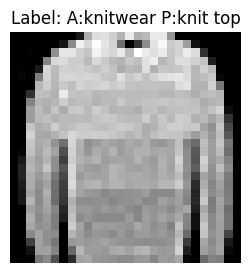

In [35]:
ims, inp, tgt = next(iter(vision_dl['valid']))

idx = 20
actual_caption = tokenizer.decode(inp[idx]).split('\n')[0]  # as \n is padded to the label
pred_caption = generate_caption(model, ims[idx])

show_images(ims[idx], f"A:{actual_caption} P:{pred_caption}")

In [36]:
actual_caption, pred_caption

('knitwear', 'knit top')

In [37]:
find_lbl(actual_caption), find_lbl(pred_caption)

([2], [2])

### Text

In [38]:
#|export

@torch.no_grad()
def generate_text(model, prompt, max_new_tokens=100, temperature=1.0):
    """
    prompt: string to start generation
    max_new_tokens: how many tokens to generate
    temperature: higher = more random, lower = more deterministic
    """
    model.eval()
    tokens = tokenizer.encode(prompt)
    tokens = torch.tensor(tokens).unsqueeze(0)  # Add batch dim
    tokens = tokens.to(multiConfig.device)
    for _ in range(max_new_tokens):
        # Crop to last seq_len tokens if needed
        context = tokens if tokens.size(1) <= model.embed.pos_ids.size(0) else tokens[:, -model.embed.pos_ids.size(0):]

        # Get predictions
        with torch.no_grad(), torch.autocast(device_type=multiConfig.device, dtype=torch.bfloat16):
          logits = model(context)
        logits = logits[:, -1, :] / temperature  # Focus on last token

        # Sample next token
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append to sequence
        tokens = torch.cat([tokens, next_token], dim=1)

    return tokenizer.decode(tokens.squeeze().tolist())

In [39]:
print(generate_text(model, "To be or not to be", max_new_tokens=256))

To be or not to before bloody work
The proud sonsent much all proupht cousing distream'd
A thrue shall confess of me; and change,
Corrowing erger to Keep and Henry's hand York
Them of subjects of a cousin.

MENENIUS:
My country.

First ANGELO:
Villain? shall he more.

LUCIO
